# Projeto 2
## Introdução a Data Science
### Alunos
Gabriel de Melo Evangelista (gme@cin.ufpe.br)

Maria Luísa Leandro de Lima (mlll@cin.ufpe.br)
### Tema: Powerlifting
https://openpowerlifting.gitlab.io/opl-csv/bulk-csv-docs.html

### Leitura dos dados limpos 

### Imports

In [5]:
import os
import sys
import pickle
import mlflow
import logging
import warnings
import optuna
import numpy as np
import pandas as pd
import mlflow.sklearn
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
df = pd.read_csv('../powerlifting_clean.csv')

Como o peso do atleta é um atributo extremamente interessante de se analisar para efeitos de comparação com seus feitos de levantamento, iremos tentar prever tal peso baseado em outros atributos das competições. Logo, para a classificação, a coluna BodyweightKg_dist será definida como categórica e será nossa label.

In [7]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
        df[str(col + "C")] = df[col].cat.codes

In [8]:
df.dtypes

Name                  category
Sex                      int64
Event                 category
Equipment             category
Division              category
BodyweightKg           float64
WeightClassKg         category
Best3SquatKg           float64
Best3BenchKg           float64
Best3DeadliftKg        float64
TotalKg                float64
Place                    int64
Dots                   float64
Wilks                  float64
Glossbrenner           float64
Goodlift               float64
EquipmentC                int8
DivisionC                int16
WeightClassKgC           int16
PlaceC                   int64
NameC                    int32
Age                    float64
Age_log                float64
BodyweightKg_log       float64
total_bodyweight       float64
BodyweightKg_dist     category
Age_dist              category
EventC                    int8
BodyweightKg_distC        int8
Age_distC                 int8
dtype: object

### 1. Escolha da Coluna

Como expresso no outro notebook, a coluna BodyweightKg_dist será utilizada para classificação. 

As colunas Dots, Glossbrenner, Wilks e Goodlift não serão usadas pois em seus cálculos o peso corporal do atleta é usado.

In [9]:
df.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Division', 'BodyweightKg',
       'WeightClassKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg',
       'TotalKg', 'Place', 'Dots', 'Wilks', 'Glossbrenner', 'Goodlift',
       'EquipmentC', 'DivisionC', 'WeightClassKgC', 'PlaceC', 'NameC', 'Age',
       'Age_log', 'BodyweightKg_log', 'total_bodyweight', 'BodyweightKg_dist',
       'Age_dist', 'EventC', 'BodyweightKg_distC', 'Age_distC'],
      dtype='object')

In [10]:
df.describe()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,...,WeightClassKgC,PlaceC,NameC,Age,Age_log,BodyweightKg_log,total_bodyweight,EventC,BodyweightKg_distC,Age_distC
count,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,...,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.0,568810.000000,568810.000000
mean,0.723514,82.072621,175.282608,113.651458,196.450341,485.383884,3.448582,359.527521,357.927874,336.611051,...,77.682771,28.012354,101043.531118,28.268291,1.418747,1.900668,5.961761,0.0,4.496141,2.056813
std,0.447268,20.687036,50.785754,39.608544,49.093086,132.870017,4.738064,47.998261,47.836152,48.492746,...,43.955096,29.547787,57436.637244,11.754245,0.163417,0.108533,1.102719,0.0,2.871825,1.418770
min,0.000000,38.050000,15.880000,20.000000,20.410000,178.000000,1.000000,248.600000,247.220000,236.230000,...,0.000000,0.000000,0.000000,8.500000,0.929419,1.580355,2.341295,0.0,0.000000,0.000000
25%,0.000000,66.500000,135.000000,80.000000,155.000000,375.000000,1.000000,322.150000,320.712500,299.060000,...,38.000000,0.000000,51785.000000,19.500000,1.290035,1.822822,5.154424,0.0,2.000000,1.000000
50%,1.000000,80.900000,175.000000,115.000000,200.000000,492.500000,2.000000,359.430000,357.750000,336.770000,...,86.000000,32.000000,101380.000000,24.500000,1.389166,1.907949,5.954825,0.0,4.000000,2.000000
75%,1.000000,94.200000,210.000000,142.500000,235.000000,587.500000,4.000000,396.940000,395.150000,374.100000,...,117.000000,43.000000,150602.750000,34.000000,1.531479,1.974051,6.749156,0.0,7.000000,3.000000
max,2.000000,163.900000,367.500000,260.820000,380.000000,850.000000,120.000000,473.270000,469.220000,455.670000,...,143.000000,119.000000,201539.000000,78.000000,1.892095,2.214579,9.082308,0.0,9.000000,4.000000


In [11]:
data = df[['Sex', 'Dots', 'DivisionC', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'PlaceC', 'Age','BodyweightKg']]

In [12]:
X = df[['Sex', 'BodyweightKg', 'Best3BenchKg', 'Best3DeadliftKg', 'PlaceC', 'Age', 'EquipmentC', 'DivisionC']]
y = df['Best3SquatKg']

In [13]:
y

0          80.0
1         105.0
2         137.5
3         232.5
4          80.0
          ...  
568805    162.5
568806    190.0
568807    180.0
568808    185.0
568809    220.0
Name: Best3SquatKg, Length: 568810, dtype: float64

In [14]:
X.dtypes

Sex                  int64
BodyweightKg       float64
Best3BenchKg       float64
Best3DeadliftKg    float64
PlaceC               int64
Age                float64
EquipmentC            int8
DivisionC            int16
dtype: object

As features utilizadas são colocadas na matriz X enquanto que a coluna a ser prevista é colocada no y.

### 2. Entendimento dos dados

In [176]:
from sklearn.decomposition import PCA
import sklearn
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# data = PCA(n_components = 2).fit_transform(X_scaled)

In [177]:
def viz(viz_tecnique, params, data, scaler):
    reducer = None
    scale = scaler()
    X_scaled = scale.fit_transform(data.drop('BodyweightKg_dist', axis = 1))
    if viz_tecnique == sklearn.decomposition.PCA:
        reducer = viz_tecnique(n_components = 2)
    elif viz_tecnique == umap.UMAP:
        reducer = viz_tecnique(**params)
    data_reduced = reducer.fit_transform(X_scaled)

    color_label = {'(38.049, 64.09]': 'blue', '(64.09, 74.1]': 'red', '(99.1, 163.9]': 'green', '(84.9, 99.1]': 'magenta', '(74.1, 84.9]': 'yellow'}

    label_color = [color_label[x] for x in data['BodyweightKg_dist']]

    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=label_color)
    team_patches = [mpatches.Patch(color=color, label=team) for team, color in color_label.items()]
    plt.legend(handles=team_patches, loc='upper right')
    plt.show()

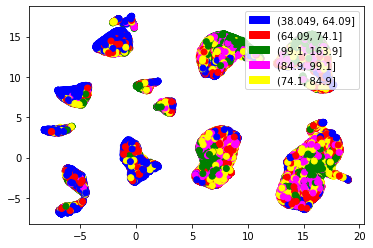

In [18]:
viz(umap.UMAP, {'n_neighbors':50}, data.sample(frac=0.1), MinMaxScaler)

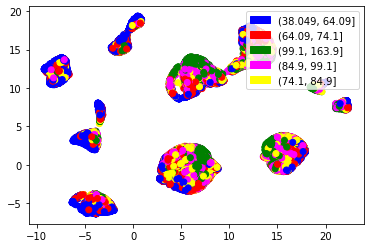

In [34]:
viz(umap.UMAP, {'n_neighbors':100}, data.sample(frac=0.1), MinMaxScaler)

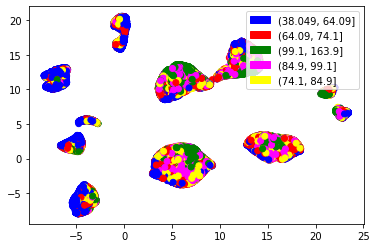

In [35]:
viz(umap.UMAP, {'n_neighbors':150}, data.sample(frac=0.1), MinMaxScaler)

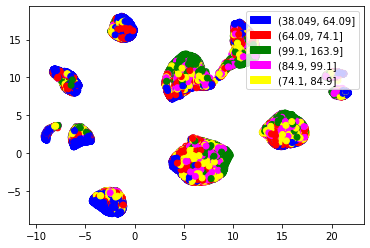

In [36]:
viz(umap.UMAP, {'n_neighbors':100, 'metric': 'manhattan'}, data.sample(frac=0.1), MinMaxScaler)

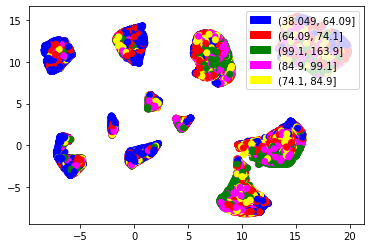

In [37]:
viz(umap.UMAP, {'n_neighbors':100, 'metric': 'cosine'}, data.sample(frac=0.1), MinMaxScaler)

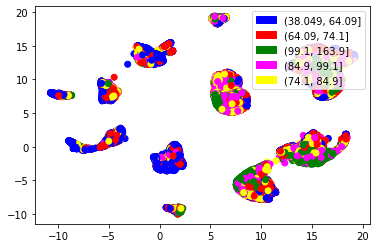

In [38]:
viz(umap.UMAP, {'n_neighbors':100, 'metric': 'chebyshev'}, data.sample(frac=0.1), MinMaxScaler)

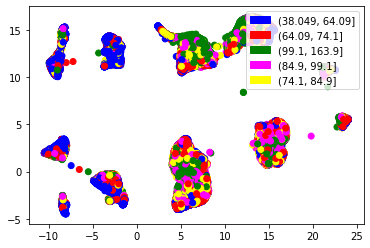

In [39]:
viz(umap.UMAP, {'n_neighbors':200, 'metric': 'chebyshev'}, data.sample(frac=0.1), MinMaxScaler)

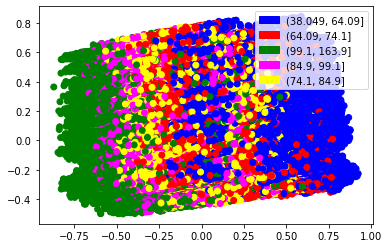

In [19]:
viz(PCA, {},data, MinMaxScaler)

In [20]:
data.shape

(568810, 9)

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# scale = MinMaxScaler()
# X_scaled = scale.fit_transform(data.drop('Bodyweight_dist', axis = 1))
kmeans = KMeans(n_clusters=5)
kmeans.fit(data.drop('BodyweightKg_dist', axis = 1))

KMeans(n_clusters=5)

<Figure size 720x504 with 0 Axes>

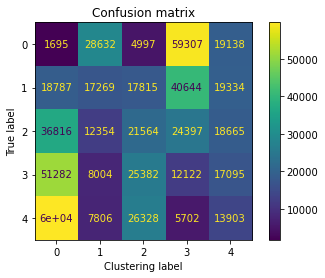

InvalidIndexError: (slice(None, None, None), 0)

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y, kmeans.labels_)

plt.figure(figsize = (10,7))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Clustering label')
plt.show()

plt.scatter(data.drop('BodyweightKg_dist', axis = 1)[:, 0], data.drop('BodyweightKg_dist', axis = 1)[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.7)


### 3. Separação dos dados

Para realizar a separação dos dados será utilizada a função "train_test_split" do sklearn.

Os dados serão separados em 50% para treino, 25% para validação e 25% para teste. Para isso, será utilizada a função 2 vezes como observado abaixo.

In [15]:
X_train, x_f, y_train, y_f = train_test_split(X, y, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(x_f, y_f, test_size = 0.5)

In [16]:
X.shape

(568810, 8)

In [17]:
X_train.shape

(284405, 8)

In [18]:
X_val.shape

(142202, 8)

In [19]:
X_test.shape

(142203, 8)

Percebe-se pelos prints acima que a divisão funcionou da forma esperada.

### 4. Seleção dos algoritmos

In [20]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [21]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [22]:
class Objective(object):
    def __init__(self, model, X_train, y_train, X_val, y_val, param_distributions):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.param_distributions = param_distributions

    def __call__(self, trial):
        with mlflow.start_run(nested=True):
            param_distributions = {}
            for key in self.param_distributions.keys():
                param_distributions[key] = trial.suggest_float(str(key), self.param_distributions[key][0], self.param_distributions[key][1])
            regressor_obj = self.model(**param_distributions)
            regressor_obj.fit(self.X_train, self.y_train)
            with open("{}.pickle".format(trial.number), "wb") as fout:
                pickle.dump(regressor_obj, fout)
            pred = regressor_obj.predict(X_val)
            rmse, mae, r2 = eval_metrics(self.y_val, pred)
            mlflow.log_params(regressor_obj.get_params())
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae", mae)

            mlflow.sklearn.log_model(regressor_obj, "model")
            return rmse

In [23]:
def train(model, X_train, y_train, X_val, y_val, X_test, y_test, param_distributions={}):
    logging.basicConfig(level=logging.WARN)
    logger = logging.getLogger(__name__)

    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

    warnings.filterwarnings("ignore")
    np.random.seed(40)

    with mlflow.start_run():
        regressor_obj = Objective(model, X_train, y_train, X_val, y_val, param_distributions)
        study = optuna.create_study(study_name=model.__class__.__name__, direction="minimize")
        study.optimize(regressor_obj, n_trials=10)

        with open("{}.pickle".format(study.best_trial.number), "rb") as fin:
            lr = pickle.load(fin)
        params = study.best_params
        predicted_qualities = lr.predict(X_val)
        (rmse, mae, r2) = eval_metrics(y_val, predicted_qualities)

        # Print out metrics
        print(str(model)+" model " + str(params))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)
        b = pd.DataFrame({'True':y_val, 'Pred':predicted_qualities}).sort_values(by='True').reset_index()
        fig, ax = plt.subplots(1, 2, figsize=(30,10))
        ax[0].plot(b['True'])
        ax[1].plot(b['Pred'])
        plt.show()

[I 2022-09-23 19:43:41,541] A new study created in memory with name: ABCMeta
[I 2022-09-23 19:43:46,187] Trial 0 finished with value: 19.258830433276486 and parameters: {'alpha': 0.23525529901328301}. Best is trial 0 with value: 19.258830433276486.
[I 2022-09-23 19:43:50,118] Trial 1 finished with value: 19.258829610342897 and parameters: {'alpha': 1.882844218746277}. Best is trial 1 with value: 19.258829610342897.
[I 2022-09-23 19:43:53,739] Trial 2 finished with value: 19.258829864365218 and parameters: {'alpha': 1.373550944901795}. Best is trial 1 with value: 19.258829610342897.
[I 2022-09-23 19:43:57,285] Trial 3 finished with value: 19.258829909690373 and parameters: {'alpha': 1.2827453436401917}. Best is trial 1 with value: 19.258829610342897.
[I 2022-09-23 19:44:00,877] Trial 4 finished with value: 19.2588301454874 and parameters: {'alpha': 0.8106723503411055}. Best is trial 1 with value: 19.258829610342897.
[I 2022-09-23 19:44:04,450] Trial 5 finished with value: 19.25883029014

<class 'sklearn.linear_model._ridge.Ridge'> model {'alpha': 1.882844218746277}
  RMSE: 19.258829610342897
  MAE: 14.242709484559208
  R2: 0.8558317306517916


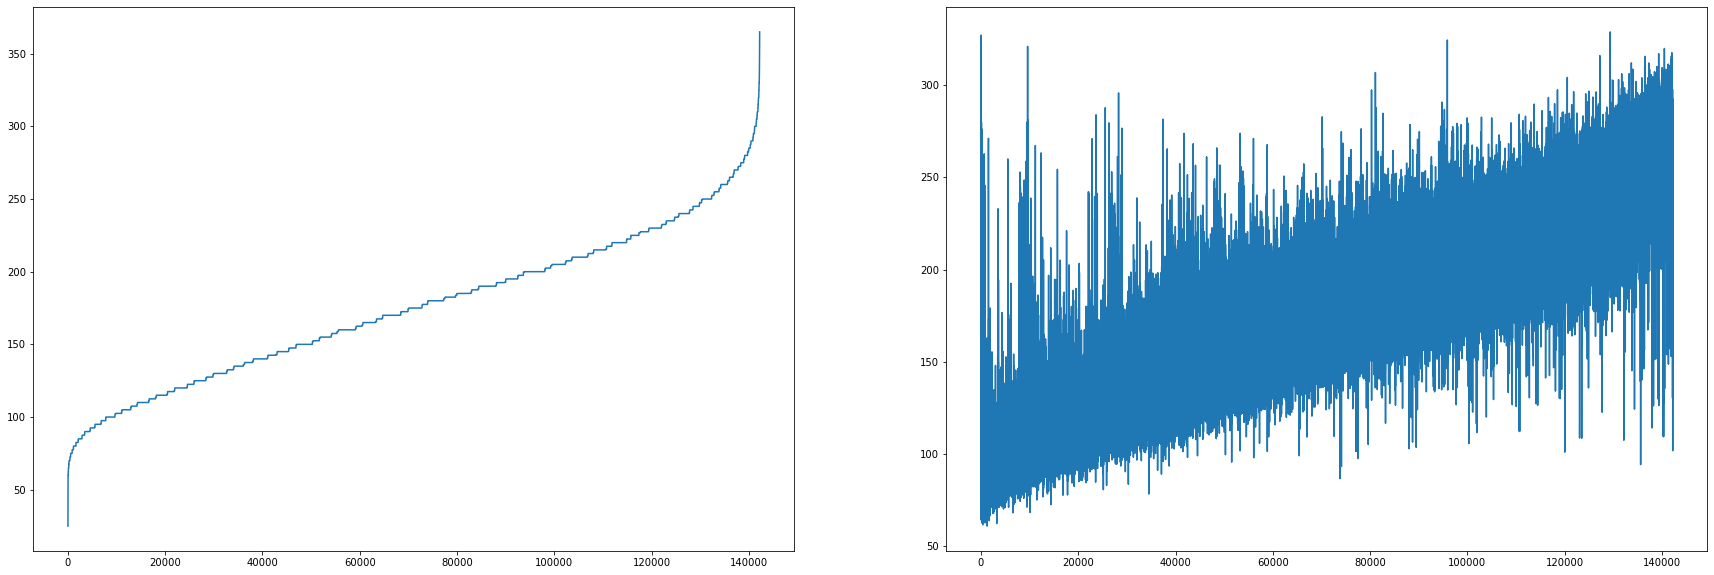

In [24]:
param_distributions = {
    "alpha": [0, 2]
}
train(Ridge, X_train, y_train, X_val, y_val, X_test, y_test, param_distributions)

{}
<class 'sklearn.tree._classes.DecisionTreeRegressor'> model {}
  RMSE: 25.6666325067073
  MAE: 18.878599281304062
  R2: 0.7445523630825771


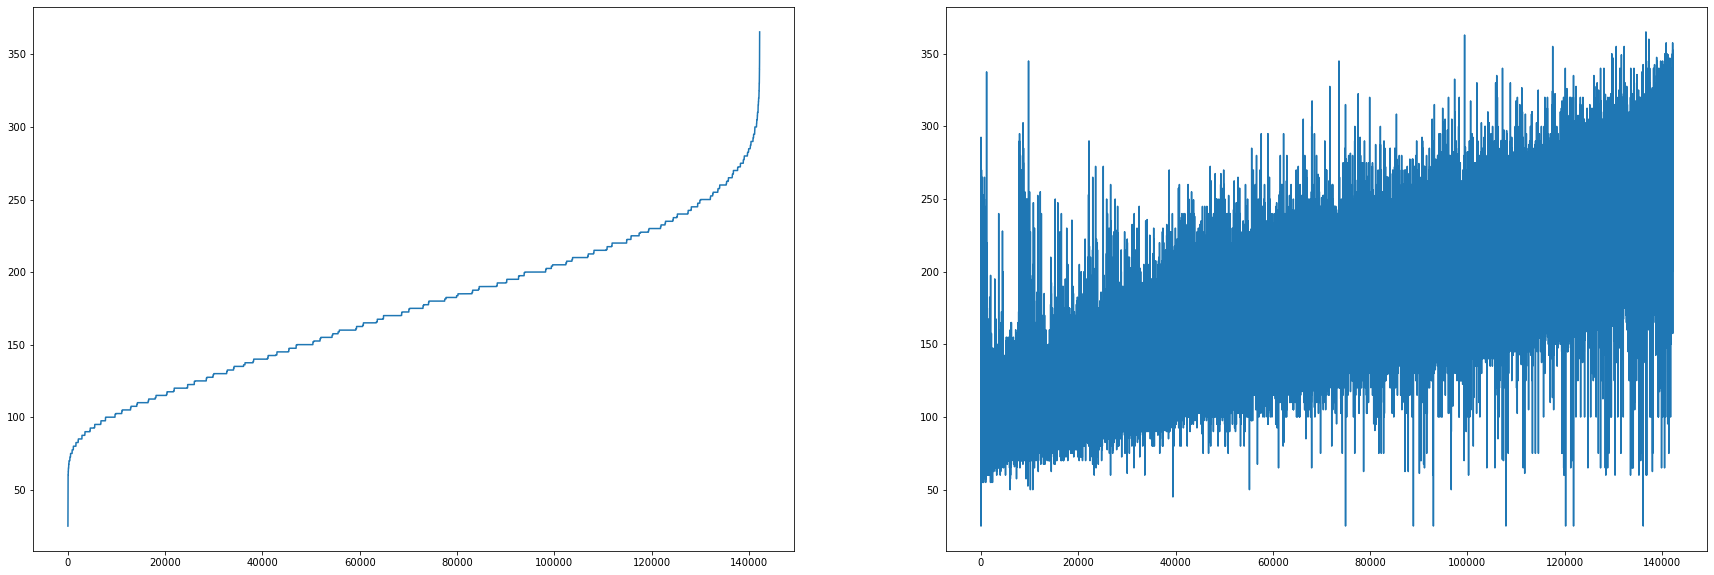

In [20]:
train(DecisionTreeRegressor, X_train, y_train, X_val, y_val, X_test, y_test)

{}
<class 'sklearn.neighbors._regression.KNeighborsRegressor'> model {}
  RMSE: 21.047947747854707
  MAE: 15.89156677121278
  R2: 0.8282156410959967


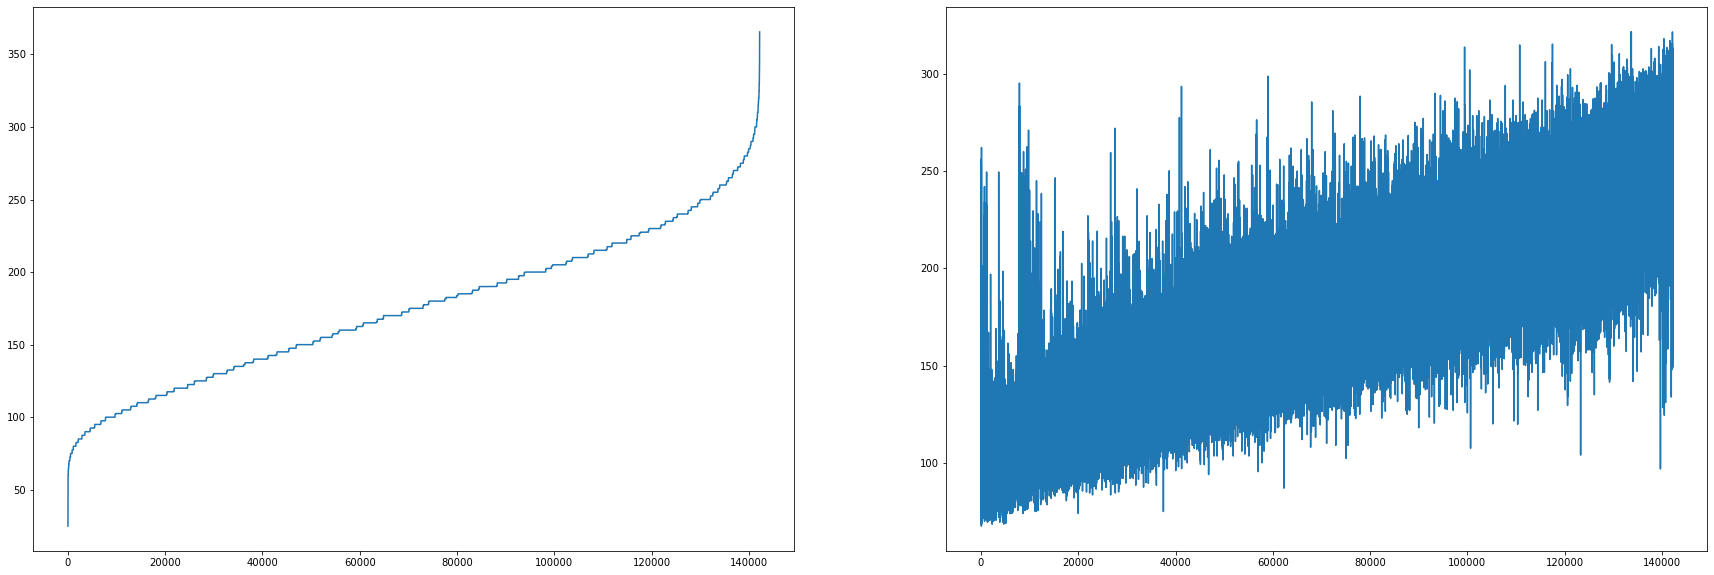

In [21]:
train(KNeighborsRegressor, X_train, y_train, X_val, y_val, X_test, y_test)

{}
<class 'xgboost.sklearn.XGBRegressor'> model {}
  RMSE: 18.1908768011007
  MAE: 13.643048886961077
  R2: 0.8716867900179861


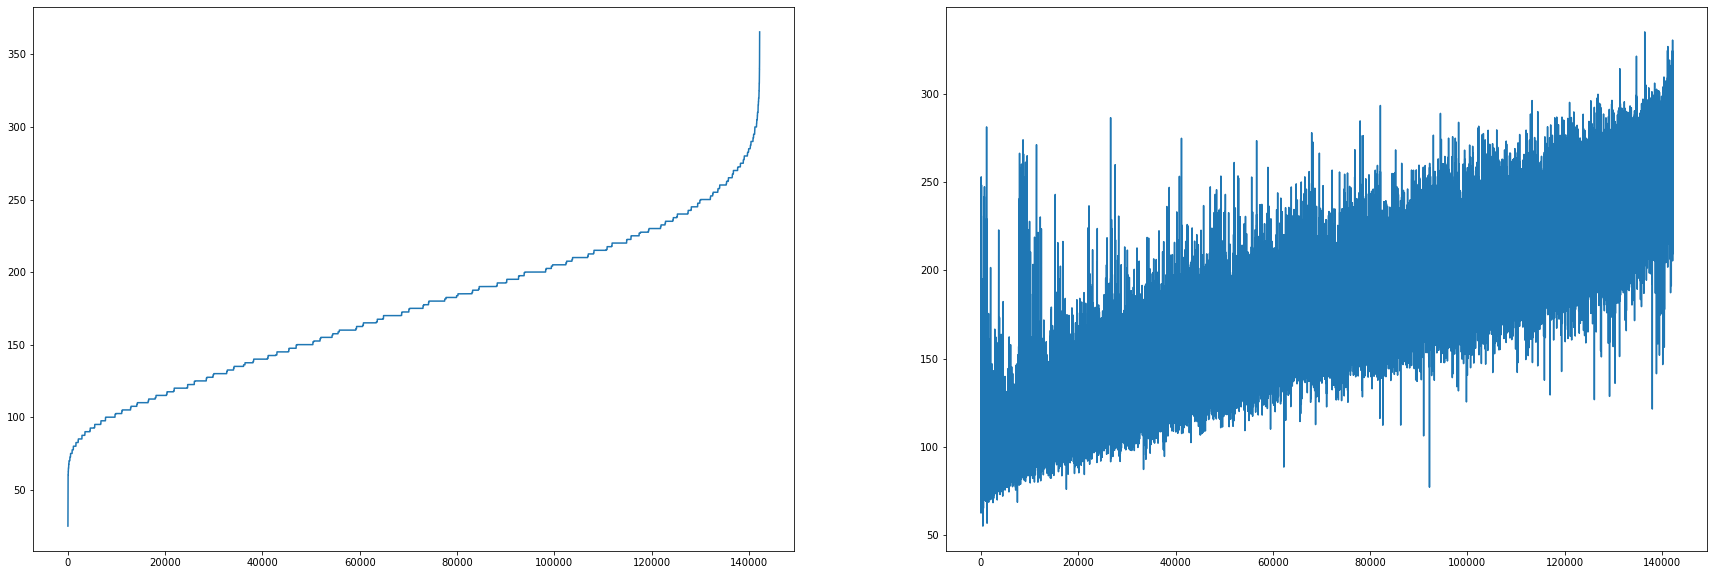

In [22]:
train(XGBRegressor, X_train, y_train, X_val, y_val, X_test, y_test)

{}
<class 'sklearn.ensemble._forest.RandomForestRegressor'> model {}
  RMSE: 18.341341414695577
  MAE: 13.655266326032857
  R2: 0.8695553430973759


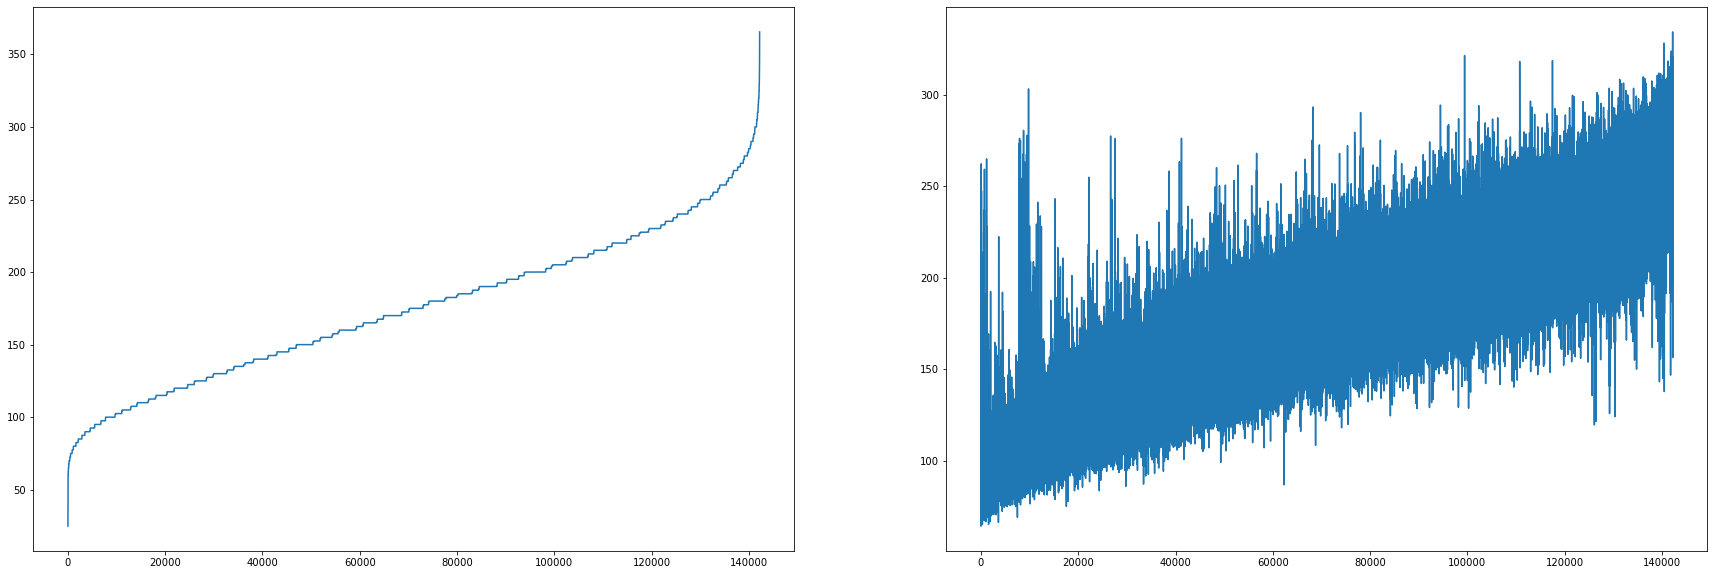

In [23]:
train(RandomForestRegressor, X_train, y_train, X_val, y_val, X_test, y_test)

{}
<class 'sklearn.svm._classes.LinearSVR'> model {}
  RMSE: 33.16213606903733
  MAE: 27.191771755033635
  R2: 0.5735686763043872


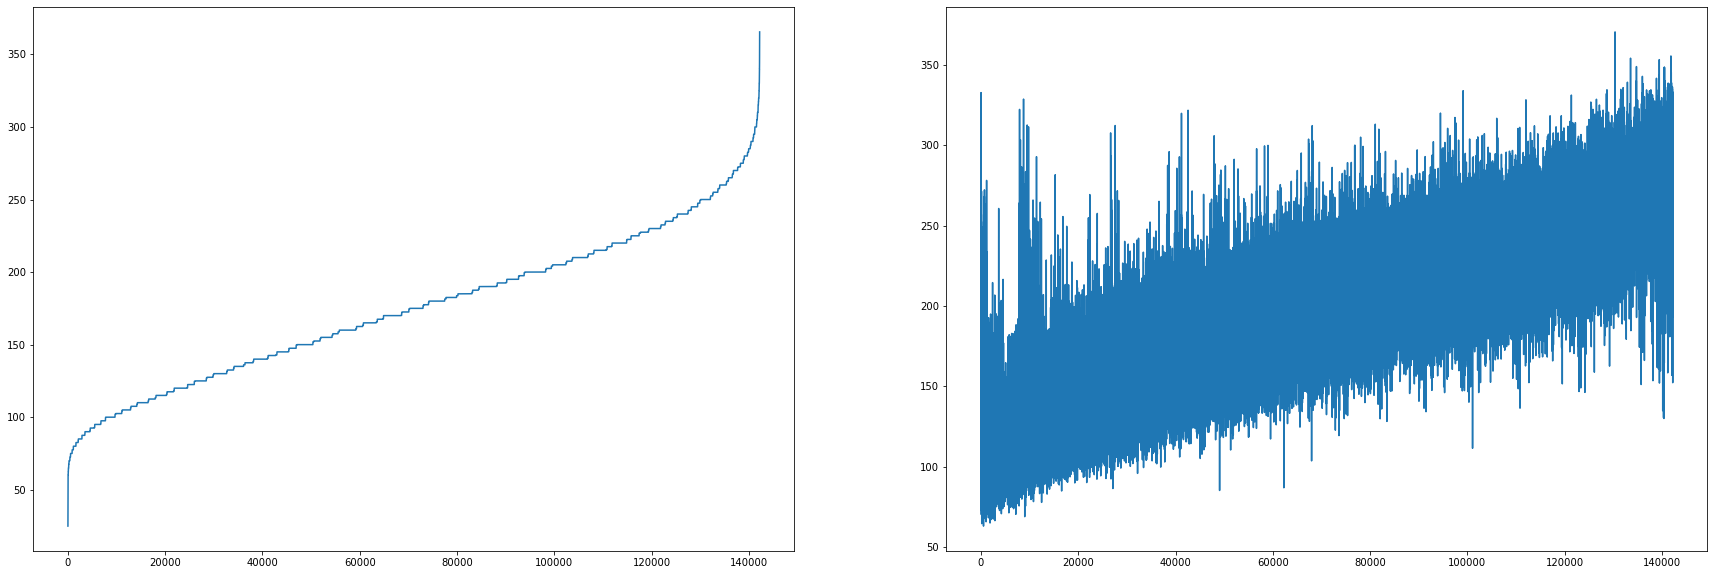

In [24]:
train(LinearSVR, X_train, y_train, X_val, y_val, X_test, y_test)